In [40]:


from sklearn import preprocessing
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, RFE, VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
import scipy.stats as stats
import pandas as pd 
import numpy as np 
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
%matplotlib inline

In [77]:
def zscore_wikipedia_entered(data_frame, columns):
    """
    Normalizing column values based on mean and std of articles with same Wikipedia age
    :param data_frame: A pandas DataFrame to be processed
    :param columns: List of column names of categorical variables 
    :returns data_frame: DataFrame with normalizedcolumns
    """  
   
    data_frame = data_frame.reset_index()
    for col in columns:
        for enter in data_frame["entered"].unique():
            temp = data_frame[data_frame["entered"]==enter]
            mean = np.mean(temp[col].values)
            std = np.std(temp[col].values)
            temp[col] = (temp[col] - mean)/std
            #print(stats.zscore(temp[col].values))
            data_frame.update(temp[col])
        
    return data_frame

def normalize(data_frame, columns):
    """
    Normalizing (loged) column values
    :param data_frame: A pandas DataFrame to be processed
    :param columns: List of column names of categorical variables 
    :returns data_frame: DataFrame with normalizedcolumns
    """    
    for col in columns:
        data_frame[col] = log_colum_values(data_frame[col])
    return data_frame

def log_colum_values(series_col):
    """
    Normalizing (loged) column values
    :param series_col: Column of dataframe 
    :returns np array: DataFrame with normalizedcolumns
    """    
    min_val = series_col.min()
    values = [log_value(v, min_val)for v in series_col.values]
    return values

def log_value(x, min_val):
    """
    Logs a value, replacing -inf with 0 and handling negative values
    :param x: value
    :param min_val: min value in list 
    :returns value: loged numerical value
    """    
    if x>0:
        return np.log(x)
    if np.log(x) == -inf:
        return 0 
    if x < 0:
#         print("na")
        return np.log(x + 1 - min_val)

def preprocess_data_frame(data_frame, columns):
    """
    Dummifying and encoding variables of dataframe, droping rows with NAN values
    :param data_frame: A pandas DataFrame to be processed
    pandas DataFrame
    :param columns: List of column names of categorical variables 
    :returns data_frame: encoded variable DataFrame
    """
    data_frame = data_frame.dropna()
    data_frame = data_frame.reset_index(drop=True)
    
    for col in columns:
#         print(data_frame[col])
        data_frame[col] = encode_variable(data_frame[col])
#         print(data_frame[col])
    data_frame = pd.get_dummies(data_frame)
    return data_frame

def encode_variable(series):
    """
    Encoding categorical variables to numericial values
    :param series: A pandas Series with categorical values
    pandas DataFrame
    :returns data_frame: encoded variable DataFrame
    """
    le = preprocessing.LabelEncoder()
    le.fit(series)
    print(list(le.classes_))
    print(set(le.transform(series))) 
    data_frame = pd.DataFrame({
        series.name: le.transform(series)
    })
    return data_frame

def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_regression, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_regression, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "Mutual Information"
    
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

def get_features_variance_threshold(data_frame,target="gender", threshold=0.2):
    """
    Returns list of features with a variance above the specified threshold
    :param data_frame: A pandas dataFrame with the training data
    :param threshold: float value between 0 and 1 
    :returns feature_scores: list of features
    """
    if target in data_frame.columns:
        data_frame = data_frame.drop([target], axis=1)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
#     print(feat_ix_keep)
    return data_frame.columns[feat_ix_keep]

def get_features_univariate(data_frame, k=5, linear=True, target="gender"):
    """
    Returns list of features selected using the specified univariate method
    :param data_frame: A pandas dataFrame with the training data
    :param k: top k features to select  
    :returns data_frame: with selected features
    """
    df = show_kbest(data_frame,target=target,linear_rel=linear, k=k)
    df = df[df["Support"] == True]
    columns = df["Attribute"].values
    return columns

def get_features_rfe(data_frame,model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame.drop("gender", axis=1)
    y = data_frame["gender"]
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return list(df[df["support"] == True]["feature"])

def split_dataframe(data_frame, target):
    """
    Split dataframe to predictors and target
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :returns DataFrames: X (predictors) and y (target) dataframes 
    """
    X = data_frame.drop([target], axis=1)
    y = pd.DataFrame(data_frame[target], columns=[target])
    return X, y 

def model_score(X,y, model):
    """
    Cross validation scores - R^2,mae,mse...
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model: Sklearn estimator object
    :returns tuple: name, r^2, mae, nmsle, mse
    """ 
    r2 = cross_val_score(model, X, y,cv=10,scoring="r2").mean()
    mae = cross_val_score(model, X, y,cv=10,scoring="median_absolute_error").mean()
    msle = cross_val_score(model, X, y,cv=10,scoring="mean_absolute_error").mean()
    mse = cross_val_score(model, X, y,cv=10,scoring="mean_squared_error").mean()
    return r2,mae,msle,mse


def score_comparison(X,y, model_dict, col_names=["Model","R^2","MEDAE","MAE","MSE"]):
    """
    DataFrame with model scores
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets
    :param model_dict: Model names are keys, sklearn estimatir objects
    :param col_names: Names of DataFrame columns
    :returns tuple: name, r^2, mae, nmsle, mse
    """ 
    lst = []
    for name,model in model_dict.items():
        r2,mae,msle,mse = model_score(X,y,model)
        lst.append([name,r2,mae,msle,mse])
    return pd.DataFrame(lst, columns=col_names)

def model_coefs(X,y, model_dict):
    """
    Returns a dataframe with coefficients for each of the models
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model_dict: Model names are keys, sklearn estimatir objects
    :returns data_frame: DataFrame with coefficients for each of the models
    """ 
    dic  = {}
    for name, model in model_dict.items():
        m = model.fit(X,y)
        try:
            dic[name] = m.coef_.flatten()
        except:
            None
    dic["Attribute"] = X.columns
    
    return pd.DataFrame(dic)

def important_features(X,y, model_dict):
    """
    Returns a dataframe with feature importance scores for each of the models
    :param X: A pandas DataFrame with features
    :param y: A pandas DataFrame with targets 
    :param model_dict: Model names are keys, sklearn estimatir objects
    :returns data_frame: DataFrame with feature importance scores for each of the models
    """ 
    dic  = {}
    for name, model in model_dict.items():
        m = model.fit(X,y)
        try:
            dic[name] = m.feature_importances_
        except:
            None
    dic["Attribute"] = X.columns
    
    return pd.DataFrame(dic)

def comparison_over_countries(country_dict,model,path,col_names=["Country","R^2","MEDAE","MAE","MSE"]): 
    """
    Returns a DataFrame with a comparison of results 
    :param country_dict: Dicrionary with country_name : file_name
    :param model: Sklearn estimator object
    :param col_names: Names of columns to be added
    :return data_frame: DataFrame with results
    """
    lst = []
    for country, file in country_dict.items():
        data = pd.read_pickle("{}/{}".format(path, file))
        data = preprocess_data_frame(data,["gender"])
        #data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
        data = zscore_wikipedia_entered(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
        X,y = split_dataframe(data,"views")
        r2,mae,msle,mse = model_score(X,y,model)
        lst.append([country,r2,mae,msle,mse])
    return pd.DataFrame(lst, columns=col_names)

def merge_by(df_lst, repeat="Attribute"):
    """
    Merge on Attribute
    :param df_lst: List of dataframes
    :return data_frame: 
    """
    df = pd.concat(df_lst, axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    return df

def print_latex(df, col_format="|c|c|c|c|c|"):
    """ Prints the latex syntax equivalent to the passed dataframe
    :param df: Pandas dataframe 
    :col_format : String indicating the format of columns
    """
    df = df.round(2)
    latex = df.to_latex(column_format=col_format, index=False).replace('toprule',
                                            "hline").replace('midrule',
                                            "hline").replace('bottomrule',
                                            "hline").replace("\\\\\n",
                                            "\\\\\n\\hline").replace("\hline\hline","\hline")
    print(latex)

# Load the data

In [78]:
data = pd.read_pickle("../data/final_sets/countries/model_large/2016_american")

In [79]:
data = preprocess_data_frame(data,["gender"])
print(data.head(1))

['female', 'male']
{0, 1}
   gender  entered  efficiency  eig_central  in_degree  k_core  out_degree  \
0       1     2013    0.734694      0.00004          2       7           5   

    views  age  distance_birth       ...         party1  party2  party3  \
0  1651.0   62              78       ...              1       0       0   

   other_p  is_alive_no  is_alive_unknown  is_alive_yes  year_interval_1  \
0        0            1                 0             0                0   

   year_interval_2  year_interval_3  
0                0                1  

[1 rows x 36 columns]


In [80]:
#data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
data = zscore_wikipedia_entered(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
print(data.head(1))

   index  gender  entered  efficiency  eig_central  in_degree    k_core  \
0      0       1     2013   -1.340673    -0.089015   0.129821  1.169148   

   out_degree     views  age       ...         party1  party2  party3  \
0     0.76854 -0.342232   62       ...              1       0       0   

   other_p  is_alive_no  is_alive_unknown  is_alive_yes  year_interval_1  \
0        0            1                 0             0                0   

   year_interval_2  year_interval_3  
0                0                1  

[1 rows x 37 columns]


In [81]:
X,y = split_dataframe(data,"views")

In [82]:
# X.shape

In [83]:
# y

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)
y_train = pd.DataFrame(y_train, columns=y.columns)
y_test =pd.DataFrame(y_test, columns=y.columns)

In [85]:
# show_kbest(data,target="views",linear_rel=False,k=5)

In [86]:
# get_features_variance_threshold(data,target="views",threshold=0.8)

In [87]:
# reg.coef_

# Views Distribution

TypeError: slice indices must be integers or None or have an __index__ method

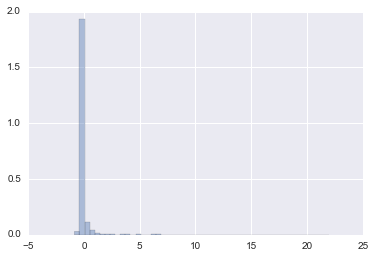

In [88]:
sns.distplot(data["views"])

# Algorithms

In [89]:
#Linear Regression
lin_reg = linear_model.LinearRegression()
#Ridge Regression
ridge = linear_model.Ridge(alpha = .5)
#Lasso Regression
lasso = linear_model.Lasso(alpha = 0.1)
#Decision Tree Regressor
d_tree = DecisionTreeRegressor(random_state=0)
#Random Forest Regressor 
r_forest = RandomForestRegressor(max_depth=2, random_state=0)

In [90]:
model_dict = {
    "Linear Regression":lin_reg,
    "Lasso Regression": lasso,
#     "Ridge Regression": ridge,
    "Decision Tree Regressor": d_tree,
    "Random Forest Regressor": r_forest
}

# F-scores

In [91]:
show_kbest(data, "views", linear_rel=True,k=5)

,F Score,P Value,Support,Attribute
0,9.196082e+00,2.438492e-03,False,index
1,2.179737e+01,3.114024e-06,False,gender
2,4.713566e-25,1.000000e+00,False,entered
3,8.492953e-02,7.707378e-01,False,efficiency
4,9.896245e+02,2.094581e-197,True,eig_central
5,4.458302e+02,1.203993e-94,True,in_degree
6,2.914820e+02,1.822335e-63,True,k_core
7,2.406327e+02,5.668661e-53,True,out_degree
8,1.303867e-01,7.180475e-01,False,age
9,2.729618e+01,1.820571e-07,False,distance_birth


# Mutual Information

In [92]:
show_kbest(data, "views", linear_rel=False,k=5)

,Mutual Information,P Value,Support,Attribute
0,0.029385,None,False,index
1,0.002940,None,False,gender
2,1.012935,None,True,entered
3,0.539286,None,False,efficiency
4,0.646623,None,True,eig_central
5,0.915072,None,True,in_degree
6,0.927348,None,True,k_core
7,0.886313,None,True,out_degree
8,0.032193,None,False,age
9,0.071835,None,False,distance_birth


# Model Comparison

In [93]:
df = score_comparison(X,y,model_dict)

In [94]:
df

,Model,R^2,MEDAE,MAE,MSE
0,Linear Regression,0.101864,-0.162321,-0.325170,-0.796285
1,Random Forest Regressor,0.054545,-0.121793,-0.275749,-0.880760
2,Lasso Regression,0.113979,-0.142853,-0.295278,-0.835794
3,Decision Tree Regressor,-1.914269,-0.041881,-0.376623,-1.978450


In [95]:
print_latex(df)

\begin{tabular}{|c|c|c|c|c|}
\hline
                   Model &   R\textasciicircum 2 &  MEDAE &   MAE &   MSE \\
\hline
       Linear Regression &  0.10 &  -0.16 & -0.33 & -0.80 \\
\hline Random Forest Regressor &  0.05 &  -0.12 & -0.28 & -0.88 \\
\hline        Lasso Regression &  0.11 &  -0.14 & -0.30 & -0.84 \\
\hline Decision Tree Regressor & -1.91 &  -0.04 & -0.38 & -1.98 \\
\hline
\end{tabular}



# Feature Importance

In [96]:
model_coefs(X,y,model_dict).sort_values(by="Linear Regression",ascending=False).round(4)

,Attribute,Lasso Regression,Linear Regression
23,act,0.0000,0.9459
28,party3,0.0000,0.5159
27,party2,0.0000,0.3959
29,other_p,-0.0000,0.3896
26,party1,-0.0000,0.3534
4,eig_central,0.2815,0.3478
16,sci,0.0000,0.1970
32,is_alive_yes,0.0000,0.1957
15,wrt,0.0000,0.1652
5,in_degree,0.0739,0.1447


In [97]:
important_features(X,y,model_dict)

,Attribute,Decision Tree Regressor,Random Forest Regressor
0,index,0.106616,0.000000
1,gender,0.042221,0.000000
2,entered,0.030375,0.000000
3,efficiency,0.059059,0.012445
4,eig_central,0.261177,0.714468
5,in_degree,0.158466,0.105736
6,k_core,0.032720,0.000000
7,out_degree,0.068095,0.024028
8,age,0.008915,0.000000
9,distance_birth,0.064651,0.010346


In [ ]:
merge_by([important_features(X,y,model_dict),model_coefs(X,y,model_dict)])

## Country comparison

In [98]:
country_dict = {
    "USA": "2016_american",
    "Germany": "2016_german",
    "France": "2016_french",
    "GB": "2016_british",
    "Russia": "2016_russian",
} 

In [99]:
path = "../data/final_sets/countries/model"
df = comparison_over_countries(country_dict, lin_reg, path)

['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}


In [100]:
df.round(2)

,Country,R^2,MEDAE,MAE,MSE
0,Russia,0.48,-0.67,-0.81,-1.13
1,USA,0.49,-0.72,-0.91,-1.41
2,Germany,0.50,-0.69,-0.81,-1.06
3,France,0.56,-0.58,-0.72,-0.87
4,GB,0.37,-0.60,-0.73,-0.88


In [101]:
path = "../data/final_sets/countries/model_large"
df = comparison_over_countries(country_dict, lin_reg, path)

['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}
['female', 'male']
{0, 1}


In [ ]:
df

In [ ]:
print_latex(df)

In [ ]:
def feature_importances(country_dict, path, model_dict):
    lst = []
    for country, file in country_dict.items():
        data = pd.read_pickle("{}/{}".format(path, file))
        data = preprocess_data_frame(data,["gender"])
        data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
        X,y = split_dataframe(data,"views")
        lst.append(model_coefs(X,y,model_dict).sort_values(by="Attribute",ascending=False).drop(["Lasso Regression"], axis =1).round(4))
    return lst

In [ ]:
path = "../data/final_sets/countries/model/"
lst = feature_importances(country_dict, path, model_dict)

In [ ]:
df = pd.DataFrame({
    "Attribute": lst[0]["Attribute"].values,
    "USA":lst[0]["Linear Regression"].values,
    "Germany":lst[1]["Linear Regression"].values,
    "France":lst[2]["Linear Regression"].values,
    "Great Britain":lst[3]["Linear Regression"].values,
    "Russia":lst[4]["Linear Regression"].values  
})

In [ ]:
df

In [ ]:
print_latex(df)

In [ ]:
coefficients = model_coefs(X,y,model_dict).sort_values(by="Linear Regression",ascending=False).drop(["Lasso Regression"], axis =1).round(4)
coefficients.round(4)

In [ ]:
import statsmodels.api as sm
from scipy import stats

def p_to_star(p_value):
    if p_value <= 0.001:
        return "***"
    if p_value <= 0.01:
        return "**"
    if p_value <= 0.05:
        return "*"
    return ""

def generate_coef_plot(country_dict,path):
    lst = []
    for k,v in country_dict.items():
        data = pd.read_pickle("{}/{}".format(path, v))
        data = preprocess_data_frame(data,["gender"])
        data = normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
        data = data.drop(["is_alive_unknown", "is_alive_no",],axis=1)
        X,y = split_dataframe(data,"views")
        X2 = sm.add_constant(X)
        est = sm.OLS(y, X)
        est2 = est.fit()
        p_v = pd.DataFrame(round(est2.pvalues,5), columns=["p_value"])
        coef = pd.DataFrame(round(est2.params,4),columns=["coef"])
        df = pd.concat([coef,p_v],axis=1)
        df["p_value"] = df["p_value"].apply(lambda x: p_to_star(x))
        df[k] = df.apply(lambda x: str(x["coef"])+x["p_value"], axis=1)
        lst.append(df[k])
        df = pd.concat(lst,axis=1)
        x = df.index.values
        x = pd.Series(x, index=df.index)
        x = x.replace({
            "wrt":"writer",
            "sci":"scientist",
            "jur":"journalist",
            "eco":"economist",
            "hst":"historian",
            "spo":"athleate",
            "lyr":"lawyer",
            "phs":"physician",
            "act":"actor",
            "distance_birth":"d_birth",
            "distance_death":"d_death",
            "nationality_num":"nationalities",
            "occupation_num":"occupations",
            "year_interval_1":"interval_1",
            "year_interval_2":"interval_2",
            "year_interval_3":"interval_3",
            "is_alive_unknown":"alive_unknown",
            "is_alive_yes":"is_alive"
        })
        df["Attribute"] = x
    return df

In [ ]:
path = "../data/final_sets/countries/model_large/"
table = generate_coef_plot(country_dict, path)

In [ ]:
table

In [ ]:
cols = table.columns.tolist()
cols = cols[-1:] + cols[:-1]
table = table[cols]

In [ ]:
table

In [ ]:
print_latex(table)

In [ ]:
# data = pd.read_pickle("../data/final_sets/countries/model_large/2016_american")
# data.shape

In [ ]:
### determine where does the const come from